In [1]:
%matplotlib inline

## [Validation Curves](https://scikit-learn.org/stable/modules/learning_curve.html)
- Every estimator has an error function composed of bias, variance and noise.
- Below: 3 linear regression estimators try to fit a cosine function.
    - 1st (polynomial features, degree = 1) = poor fit
    - 2nd (polynomial features, degree = 4) = very good fit
    - 3rd (polynomial features, degree = 15) = overfits = high variance.
- Very hard to visualize these models in high-D space, so these tools will help.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [3]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30; degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

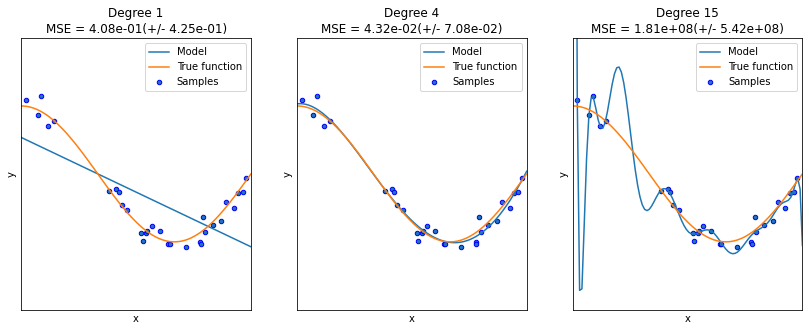

In [4]:
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression",   linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    scores = cross_val_score(pipeline, X[:, np.newaxis], 
                             y,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    X_test = np.linspace(0, 1, 100)
    
    plt.plot(X_test, 
             pipeline.predict(X_test[:, np.newaxis]), 
             label="Model")
    
    plt.plot(X_test, 
             true_fun(X_test), 
             label="True function")
    
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## [Validation Curves](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve)

- Below: training and validation scores for an SVM estimator across a range of value for ```gamma```.
- At low values of ```gamma```, both training and validation scores are bad. (This is underfitting.)
- Medium values of ```gamma``` look ok.
- High values of ```gamma``` cause the model to overfit. (good training scores, but bad validation scores.)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

X, y = load_digits(return_X_y=True)

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, 
    param_name="gamma", 
    param_range=param_range,
    scoring="accuracy", 
    n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

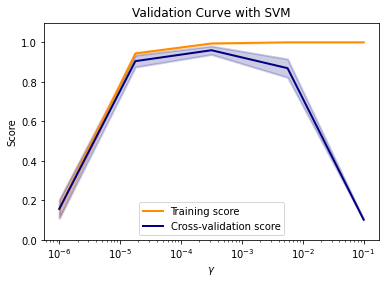

In [7]:
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, 
             train_scores_mean, 
             label="Training score",
             color="darkorange", lw=lw)

plt.fill_between(param_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2,
                 color="darkorange", lw=lw)

plt.semilogx(param_range, 
             test_scores_mean, 
             label="Cross-validation score",
             color="navy", lw=lw)

plt.fill_between(param_range, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.2,
                 color="navy", lw=lw)

plt.legend(loc="best")
plt.show()

## [Learning Curves](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve)
- shows the validation & training scores of an estimator for varying numbers of training samples. It shows the cost/benefit curve of adding training data.
- Below: learning curves for a NB classifier and an SVM.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

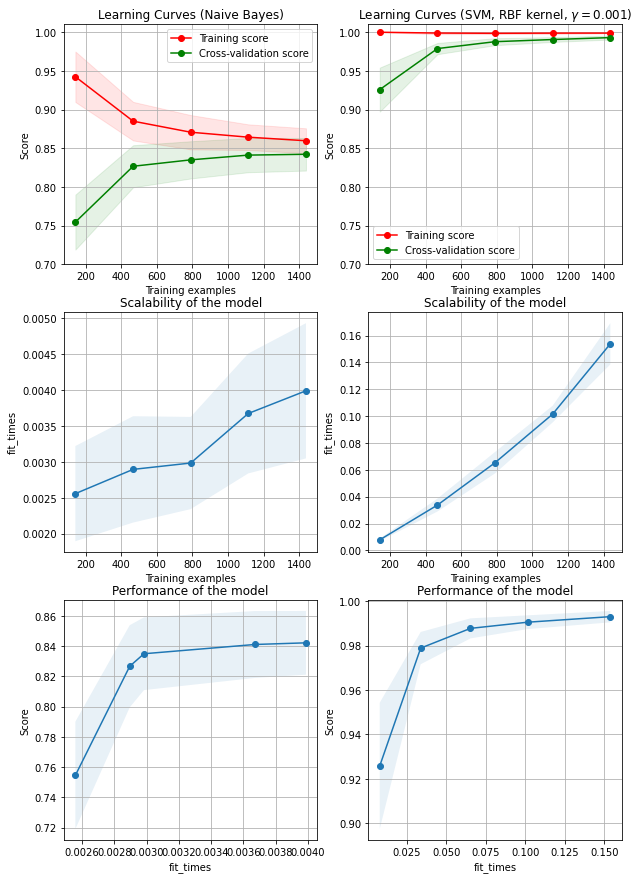

In [9]:
# generate 3 plots: test/training curve, #samples/fit times, 
# fit times vs score.
def plot_learning_curve(estimator, 
                        title, X, y, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, 
                       cv           = cv, 
                       n_jobs       = n_jobs,
                       train_sizes  = train_sizes,
                       return_times = True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    fit_times_mean    = np.mean(fit_times, axis=1)
    fit_times_std     = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, 
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, 
                         alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, 
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, 
                         alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, 
                 train_scores_mean, 
                 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, 
                 test_scores_mean, 
                 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, 
                 fit_times_mean, 
                 'o-')
    axes[1].fill_between(train_sizes, 
                         fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, 
                         alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, 
                 test_scores_mean, 
                 'o-')
    axes[2].fill_between(fit_times_mean, 
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, 
                         alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
X, y = load_digits(return_X_y=True)
title = "Learning Curves (Naive Bayes)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, 
                  test_size=0.2, 
                  random_state=0)

estimator = GaussianNB()

plot_learning_curve(estimator, 
                    title, X, y, 
                    axes=axes[:, 0], 
                    ylim=(0.7, 1.01),
                    cv=cv, 
                    n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"

# SVC is more expensive so we do a lower number of CV iterations:

cv = ShuffleSplit(n_splits=10, 
                  test_size=0.2, 
                  random_state=0)

estimator = SVC(gamma=0.001)

plot_learning_curve(estimator, 
                    title, X, y, 
                    axes=axes[:, 1], 
                    ylim=(0.7, 1.01),
                    cv=cv, 
                    n_jobs=4)

plt.show()